This notebook presents an example of an IAE training. 

To create a conda environment with all the imports needed, do:
- conda env create -f SUSHI_env.yml
- conda activate SUSHI_env
- Then open this notebook in that environment.

In [1]:
# Imports 
%matplotlib inline

#autorealod library when an external lib is changed. 
import sys, os
%load_ext autoreload  
%autoreload 2

import numpy as np 
from jax import numpy as jnp
import matplotlib.pyplot as plt
import pickle
from ipywidgets import interact, fixed
import jax
from tqdm.notebook import tqdm
if int(jax.__version__[2])<4:
    sys.path.append(os.path.abspath('/older_version/'))
    import IAE_JAX_v2_devl_2022 as mld
else:
    import IAE_JAX_v2_devl_2023 as mld
from astropy.io import fits

# Preparing the training set

Because Github only allows files under 100MB, the training/testing/validation sets (whose template was over 250MB) are here given pre-shuffled and processed. Remember: 
- to normalize the spectra (they sum to one over the energy range)
- to pick the anchor points at the extreme parameter values (here, highest z highest kT, lowest z highest kT, lowest z lowest kT, highest z lowest kT). 
- to shuffle the training and testing set.

In [2]:
with open("data/Training_Set_IAE.p","rb") as f:
    Output=pickle.load(f)
Anchor_points=Output["Psi"]

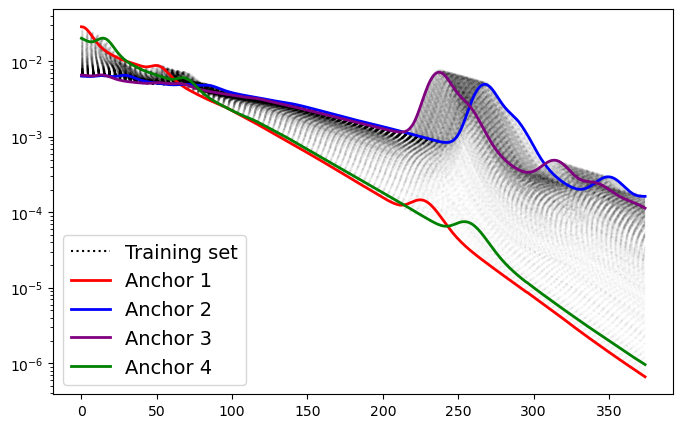

In [3]:
plt.figure(figsize=(8,5))
colors=["red","blue","purple","green"]
labs=["Anchor 1","Anchor 2","Anchor 3","Anchor 4"]

plt.plot(Output["X_train"][:,:].T, ls=':',color='k',alpha=0.01)
plt.plot([],[],label='Training set',color='k',ls=':')
for i in range(4):
    plt.plot(Anchor_points.T[:,i],color=colors[i],label=labs[i],lw=2)
plt.legend(prop={'size': 14})
#plt.title("Training Spectra")
plt.yscale("log")
plt.show()

Take the mean spectrum for weighting — this helps with spectra that vary over several orders of magnitude 

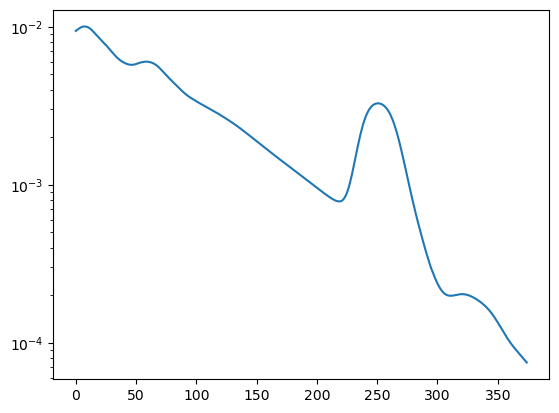

In [4]:
Mean=np.mean(Output["X_train"],axis=0)
plt.plot(Mean)
plt.yscale("log")

# Training

Sometimes, on complex models, the training is found to work best by training a first guess model with less layers, then learning with more layers. 

In [14]:
def save_model(fname,self):
    Model = ({"fname": fname,
                 "AnchorPoints": self.AnchorPoints,
                 "Params": self.Params,
                 "NSize": self.NSize,
                 "nlayers": self.nlayers,
                 "active_forward": self.active_forward,
                 "active_backward": self.active_backward,
                 "res_factor": self.res_factor,
                 "reg_parameter": self.reg_parameter,
                 "cost_weight": self.cost_weight,
                 "simplex": self.simplex,
                 "nneg_output": self.nneg_output,
                 "nneg_weights": self.nneg_weights,
                 "noise_level": self.noise_level,
                 "reg_inv": self.reg_inv,
                 "cost_type": self.cost_type,
                 "optim_learn": self.optim_learn,
                 "step_size": self.step_size,
                 "niter": self.niter,
                 "eps_cvg": self.eps_cvg,
                 "bn_param": self.bn_param,
                 "verb": self.verb,
                 "code_version": self.code_version,
                 "enable_train_bn":self.enable_train_bn,
                 "sparse_code":self.sparse_code,
                 "niter_sparse":self.niter_sparse})
    jnp.save(fname,arr=Model)

code version :  version_2_nov_18th_2021
simplex constraint :  True


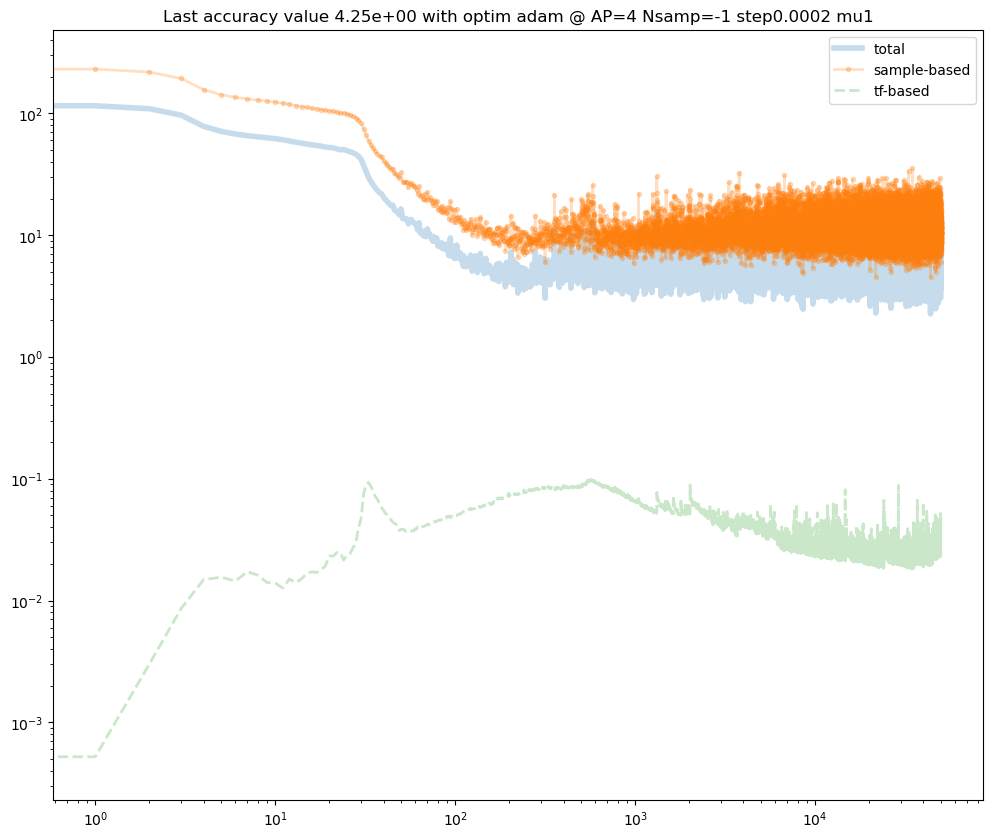

code version :  version_2_nov_18th_2021
simplex constraint :  True


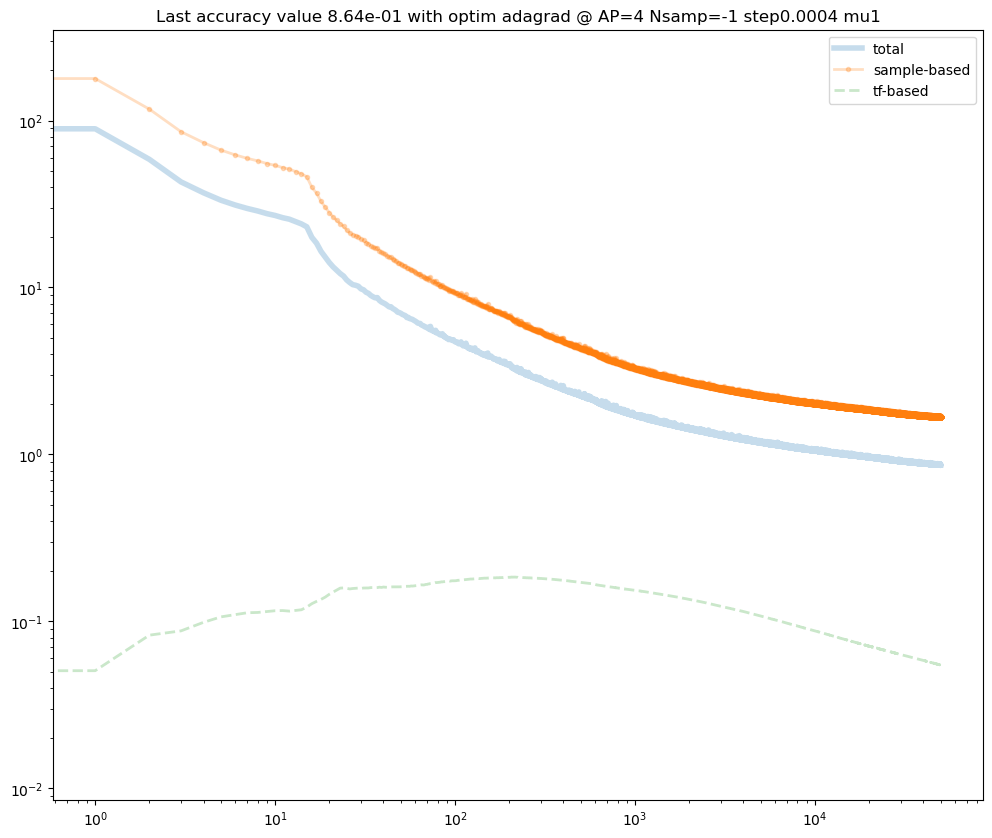

code version :  version_2_nov_18th_2021
simplex constraint :  True


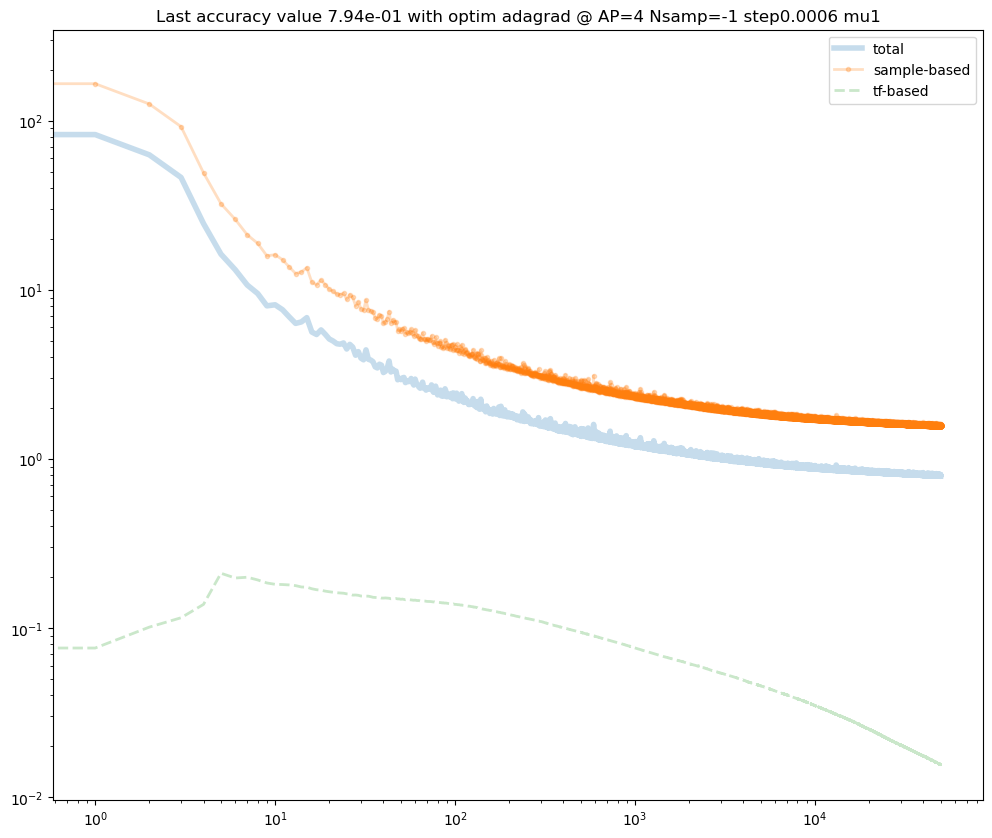

Model saved to IAE_test_IAE_linear_AP4_mu1_adagrad_test.npy 


In [20]:
mu = 1 # Regularization parameter between quality in real space or transformed space
AP=Anchor_points.shape[0] #Nb of anchor point used
nsamples = -1
name="IAE_test"
fdir='/Users/jl269817/Internship_2022_Julia/results/'
t_length= Output["X_train"].shape[-1]  
Xvalidation = Output["X_valid"][0:nsamples,:]
Optims = ['adam', 'momentum', 'rmsprop', 'adagrad', 'Nesterov', 'SGD']
Optim = 3
vNL = [2,3,4]
scaling="linear"
cost_weight=Mean
#Optimizers, niter, and stepsize is changed for each layers
niters=[5e4,5e4,5e4] 
opts = [0,3,3]
steps=[2e-4,4e-4,6e-4]

for i,NL in enumerate(vNL):  # Learning with various numbers of layers
    niter=int(niters[i]) 
    opt=opts[i]
    step=steps[i]
    if NL == 2:
        out0 = None # out0 is a first guess model
    else:
        out0['optim_learn']=opt #update values in dict otherwise keeps old values and kw not read
        out0['niter']=niter
        out0['step_size']=step
    
#    fname = f'{name}_model_L'+np.str(NL) # filename of the saved model (pickle file)
#    fname="toto"
    
    fname = f"{name}_IAE_{scaling}_AP{AP}_mu{mu}_{Optims[opt]}_test" # filename for the learnt model

    NSize = t_length*np.ones((NL+1,),dtype='int') # shape of the network
    LearnFunc = mld.IAE(fname=fname, Model=out0, simplex=True,
                                   AnchorPoints=Anchor_points, NSize=NSize, step_size=step, reg_parameter=mu, 
                                   niter=int(niters[i]), active_forward='lRelu', active_backward='lRelu', reg_inv=1e-8, 
                                   verb=True, optim_learn=opt,cost_weight=cost_weight)   # Defines the learning class
    learnt_params, outval = LearnFunc.learning_stage(Output["X_train"], XValidation= Output["X_valid"], batch_size=100)
    save_model(fname,LearnFunc)
    out0 = np.load(f"{fname}.npy",allow_pickle=True).item()
    
    plt.figure(figsize=[12,10])
    #plt.xlim(skip,niter)
    plt.loglog(outval["total_cost"], lw=4, alpha=0.25)
    plt.loglog(outval["samp_cost"], '.-', lw=2, alpha=0.25)
    plt.loglog(outval["trans_cost"],'--', lw=2, alpha=0.25)
    plt.legend(["total","sample-based","tf-based"])
    plt.title(f"Last accuracy value {float(outval['total_cost'][-1]):.2e} with optim {Optims[opt]} @ AP={AP} Nsamp={nsamples} step{step} mu{mu}")
    plt.savefig(fname+'_training.png',dpi=150)
    plt.show()

print(f'Model saved to {fname}.npy ')

# Testing

To test the quality of our training, we look at whether the trained network is capable of reconstructing spectra from the testing set, by passing them through the encoder, projecting them onto the barycentric span, then passing the output through the decoder. If the IAE has been well-trained, the majority of resulting spectra should be very close to the input test spectra.

  0%|          | 0/10 [00:00<?, ?it/s]

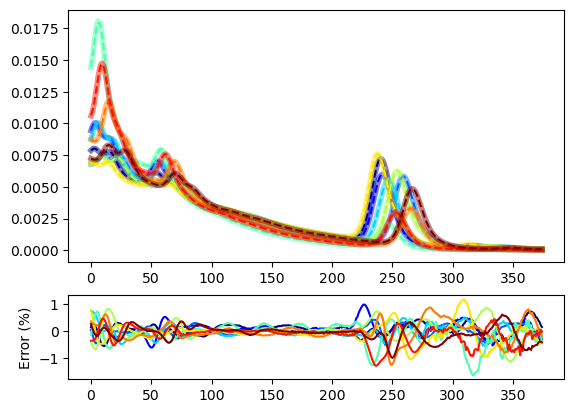

In [51]:
colors = plt.cm.jet(np.linspace(0,1,10))
Test_set=Output["X_test"]
IAE_XRec_FI=np.zeros((10,375))
fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]})
for i in tqdm(range(10)):
    spec=Test_set[i:i+1,:]
    IAE_XRec_FI[i,:]=LearnFunc.fast_interpolation(spec)["XRec"].squeeze() 
    ax[0].plot(Test_set[i,:],lw=4,alpha=0.5,color=colors[i])
    ax[0].plot(IAE_XRec_FI[i,:],"--",color=colors[i])
    ax[1].plot(100*(Test_set[i,:]-IAE_XRec_FI[i,:])/Test_set[i,:],color=colors[i])
    ax[1].set_ylabel("Error (%)")

  0%|          | 0/500 [00:00<?, ?it/s]

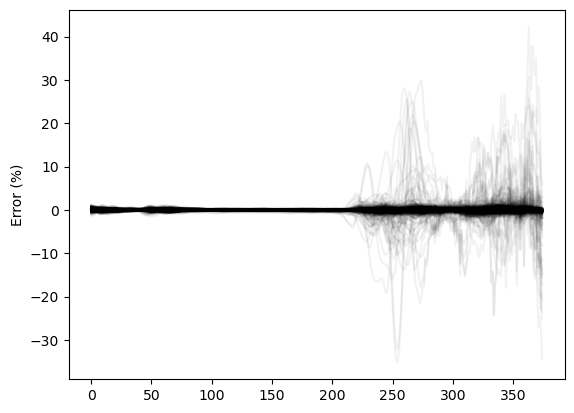

In [55]:
colors = plt.cm.jet(np.linspace(0,1,500))
Test_set=Output["X_test"]
IAE_XRec_FI=np.zeros((500,375))
for i in tqdm(range(500)):
    spec=Test_set[i:i+1,:]
    IAE_XRec_FI[i,:]=LearnFunc.fast_interpolation(spec)["XRec"].squeeze() 
    plt.plot(100*(Test_set[i,:]-IAE_XRec_FI[i,:])/Test_set[i,:],alpha=0.05,color="black")
    plt.ylabel("Error (%)")
plt.show()